# ATIS

In [ ]:
# Checking GPU Configuration
!nvidia-smi

Fri Feb  4 05:56:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    645MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# FYP Experiment 1
# Sentence Transformer  for Word-Level BERT Embedding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing/Downloading required packages into this notebook
!pip install sentence-transformers

In [ ]:
import numpy as np
from keras.models import load_model

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# NLTK Word Tokenization without Punctuation

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
import nltk
nltk.download("punkt")

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model

In [ ]:
def charCNN_input_preprocess(text):
  '''
  Takes input sentence
  Preprocesses - lowers, character level tokenization & padding
  Returns preprocessed input
  '''
  input_text = np.array([text])
  input_text = [s.lower() for s in input_text]
  tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
  tk.fit_on_texts(input_text)

  alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
  char_dict = {}
  for i, char in enumerate(alphabet):
      char_dict[char] = i + 1

  tk.word_index = char_dict.copy()
  tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

  input_sequence = tk.texts_to_sequences(input_text)
  input_data = pad_sequences(input_sequence, maxlen=1014, padding='post')
  input_data = np.array(input_data, dtype='float32')

  return input_data

In [ ]:
# CharCNN Model Loading
charCNN_model = load_model("/content/drive/MyDrive/SavedModels/charCNN")

In [ ]:
def create_intelligent_word_embedding(text):
  '''
  Takes an input query text
  Finds BERT Embedding of each word
  Finds charCNN embedding of each word
  Concatenates the above two for each word
  Returns a list of the above word representations
  '''
  charcnn_embedding = []
  bert_embedding = []
  final_embedding = []
  word_list = text.split(" ")

  for i,word in enumerate(word_list):
    bert_embedding.append(model.encode(word))
    #print("1")
    charcnn_embedding.append(np.squeeze(charCNN_model.predict(np.expand_dims(charCNN_input_preprocess(word)[0],axis = 0)),axis=0))

    final_embedding.append(np.concatenate([bert_embedding[i],charcnn_embedding[i]]))

  return final_embedding, bert_embedding, charcnn_embedding

In [ ]:
train_df = pd.read_pickle("/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_train.pkl")
valid_df = pd.read_pickle("/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_valid.pkl")
test_df = pd.read_pickle("/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_test.pkl")

In [ ]:
train_df.iloc[0]

sentences                                  show me all the delta flights leaving or arriv...
dac                                                                                  command
intents                                                                          atis_flight
slots                                      O O O O B-airline_name O O O O O B-toloc.city_...
bert_embeddings                            [[-0.11299035, -0.27697983, 0.371804, -0.56227...
charcnn_embeddings                         [[0.9620004, 0.0, 1.2165515, 0.0, 0.70012015, ...
padded_sentences                           show me all the delta flights leaving or arriv...
intelligent_concatenated_representation    [[-0.11299035, -0.27697983, 0.371804, -0.56227...
Name: 0, dtype: object

In [ ]:
# Sample Embedding
index = int(input("Enter index: "))
print("Input Query: " + train_df.iloc[index, 0])
print("BERT Embedding Shape: " , np.array(train_df.iloc[index, 4]).shape)
print("CharCNN Embedding Shape: ", np.array(train_df.iloc[index, 5]).shape)
print("Intelligent Concatenated Word Representation Shape: ", np.array(train_df.iloc[index, 7]).shape)

Enter index: 5
Input Query: list all flights from pittsburgh to philadelphia
BERT Embedding Shape:  (24, 384)
CharCNN Embedding Shape:  (24, 100)
Intelligent Concatenated Word Representation Shape:  (24, 484)


In [ ]:
print("\nIntelligent Concatenated Word Representation: ", train_df.iloc[index, 7])


Intelligent Concatenated Word Representation:  [array([ 1.05455756e-01,  5.33394776e-02, -4.75901328e-02,  4.21749264e-01,
        1.32951245e-01, -3.53912920e-01,  8.06346416e-01, -1.74798191e-01,
       -1.03638761e-01,  1.05727715e-02, -1.14848912e-01, -5.29299736e-01,
       -7.33419657e-02,  2.71434158e-01, -1.78288613e-02,  1.79571316e-01,
        4.87265736e-01, -1.29274026e-01,  3.27462345e-01, -5.07399738e-01,
        5.71645856e-01,  2.68918753e-01, -3.12753230e-01,  2.59546131e-01,
        4.33816344e-01,  8.12115192e-01, -2.94468641e-01,  2.82674823e-02,
       -1.74646690e-01, -3.78950387e-01, -4.81065989e-01,  4.74012166e-01,
        8.12968552e-01,  3.49523336e-01,  1.09348200e-01, -1.97766021e-01,
       -2.03077700e-02,  1.47855029e-01,  4.54230636e-01, -2.96758264e-02,
        3.97327393e-02, -3.99981380e-01,  3.26626189e-02,  5.15525453e-02,
       -6.53692424e-01, -5.83321035e-01, -4.97856885e-01, -8.89840245e-04,
       -2.12940410e-01,  1.79659769e-01, -6.9753837

In [ ]:
print("\nCharCNN Embedding: ", train_df.iloc[index, 5])


CharCNN Embedding:  [array([0.9620004 , 0.        , 1.2165515 , 0.        , 0.70012015,
       0.        , 1.422039  , 0.0598212 , 0.7984161 , 1.5171223 ,
       0.        , 0.36067742, 0.        , 0.8321939 , 1.2603669 ,
       0.        , 0.        , 0.5462933 , 0.96808434, 1.3488799 ,
       0.        , 0.35696313, 0.542168  , 1.2221024 , 0.26828927,
       0.96800196, 0.44237804, 0.24675098, 1.20941   , 1.3402786 ,
       0.8846285 , 0.47121418, 0.68158484, 0.        , 0.        ,
       0.7066314 , 1.439575  , 0.13860813, 0.3291201 , 0.        ,
       0.        , 0.        , 1.0211809 , 0.8308318 , 0.        ,
       0.6624733 , 0.        , 0.        , 0.08371684, 0.09087047,
       0.        , 1.2155466 , 0.7473688 , 0.6624509 , 0.33974043,
       1.0285767 , 0.12979275, 0.18740195, 0.27342975, 0.9958683 ,
       0.59755933, 0.        , 0.11815178, 0.95345926, 0.        ,
       0.52276146, 0.        , 0.5248372 , 1.1741784 , 0.65238523,
       1.064513  , 1.0615201 , 0.       

In [ ]:
print("\nBERT Embedding: ", train_df.iloc[index, 4])


BERT Embedding:  [array([ 1.05455756e-01,  5.33394776e-02, -4.75901328e-02,  4.21749264e-01,
        1.32951245e-01, -3.53912920e-01,  8.06346416e-01, -1.74798191e-01,
       -1.03638761e-01,  1.05727715e-02, -1.14848912e-01, -5.29299736e-01,
       -7.33419657e-02,  2.71434158e-01, -1.78288613e-02,  1.79571316e-01,
        4.87265736e-01, -1.29274026e-01,  3.27462345e-01, -5.07399738e-01,
        5.71645856e-01,  2.68918753e-01, -3.12753230e-01,  2.59546131e-01,
        4.33816344e-01,  8.12115192e-01, -2.94468641e-01,  2.82674823e-02,
       -1.74646690e-01, -3.78950387e-01, -4.81065989e-01,  4.74012166e-01,
        8.12968552e-01,  3.49523336e-01,  1.09348200e-01, -1.97766021e-01,
       -2.03077700e-02,  1.47855029e-01,  4.54230636e-01, -2.96758264e-02,
        3.97327393e-02, -3.99981380e-01,  3.26626189e-02,  5.15525453e-02,
       -6.53692424e-01, -5.83321035e-01, -4.97856885e-01, -8.89840245e-04,
       -2.12940410e-01,  1.79659769e-01, -6.97538376e-01,  6.12996258e-02,
      

In [ ]:
# Overall dataframe to gauge the max world length of each sentence
df = pd.concat([train_df, valid_df, test_df], axis=0,ignore_index=True)

In [ ]:
def find_max_words(query_col) :
  return max(query_col.str.split().apply(len))

find_max_words(df["sentences"])

46

In [ ]:
query_col = []
a=[query_col.append(text.split(" ")) for text in df["sentences"]]

In [ ]:
from keras.preprocessing.sequence import pad_sequences
#padded = pad_sequences(sequences=query_col, maxlen=46, dtype=object, padding='post', value="<UNK>")
padded = pad_sequences(sequences=query_col, maxlen=24, dtype=object, padding='post', truncating='post', value="<UNK>")
res = [' '.join(ele) for ele in padded]

In [ ]:
df["padded_sentences"] = res

# Splitting back to train and validation sets
train_df = df[:4480]
valid_df = df[4480:4978].reset_index(drop=True)
test_df = df[4978:].reset_index(drop=True)

In [ ]:
test_df.head()

,sentences,dac,intents,slots,bert_embeddings,charcnn_embeddings,intelligent_concatenated_word_representation,padded_sentences
0,i would like to find a flight from charlotte t...,info,atis_flight,O O O O O O O O B-fromloc.city_name O B-toloc....,NaN,NaN,NaN,i would like to find a flight from charlotte t...
1,on april first i need a ticket from tacoma to ...,info,atis_airfare,O B-depart_date.month_name B-depart_date.day_n...,NaN,NaN,NaN,on april first i need a ticket from tacoma to ...
2,on april first i need a flight going from phoe...,info,atis_flight,O B-depart_date.month_name B-depart_date.day_n...,NaN,NaN,NaN,on april first i need a flight going from phoe...
3,i would like a flight traveling one way from p...,info,atis_flight,O O O O O O B-round_trip I-round_trip O B-from...,NaN,NaN,NaN,i would like a flight traveling one way from p...
4,i would like a flight from orlando to salt lak...,info,atis_flight,O O O O O O B-fromloc.city_name O B-toloc.city...,NaN,NaN,NaN,i would like a flight from orlando to salt lak...


In [ ]:
train_df.head()

,sentences,dac,intents,slots,bert_embeddings,charcnn_embeddings,intelligent_concatenated_word_representation,padded_sentences
0,show me all the delta flights leaving or arriv...,command,atis_flight,O O O O B-airline_name O O O O O B-toloc.city_...,"[0.35384124517440796, -0.24122509360313416, 0....","[0.0, 0.0, 2.6512883, 0.0, 0.44951394, 0.0, 2....","[0.35384124517440796, -0.24122509360313416, 0....",show me all the delta flights leaving or arriv...
1,flights from cleveland to miami,info,atis_flight,O O B-fromloc.city_name O B-toloc.city_name,"[0.5080912709236145, -0.832824170589447, -0.22...","[5.834301, 0.0, 7.400481, 0.0, 5.789922, 0.0, ...","[0.5080912709236145, -0.832824170589447, -0.22...",flights from cleveland to miami <UNK> <UNK> <U...
2,which transcontinental flight on united airlin...,question,atis_flight,O O O O B-airline_name I-airline_name O B-from...,"[0.2670583128929138, 0.04522395879030228, 0.51...","[0.0, 0.0, 10.3799515, 0.0, 0.0, 0.0, 10.41155...","[0.2670583128929138, 0.04522395879030228, 0.51...",which transcontinental flight on united airlin...
3,what flights are available from boston to denv...,question,atis_flight,O O O O O B-fromloc.city_name O B-toloc.city_n...,"[0.5678922533988953, -0.4599961042404175, 0.06...","[6.738251, 0.0, 6.598054, 0.0, 7.173879, 0.0, ...","[0.5678922533988953, -0.4599961042404175, 0.06...",what flights are available from boston to denv...
4,show flights from san francisco to denver on e...,command,atis_flight,O O O B-fromloc.city_name I-fromloc.city_name ...,"[0.4919344484806061, -0.35757938027381897, 0.1...","[0.0, 0.0, 0.0, 1.7041256, 0.0, 0.0, 0.0, 1.56...","[0.4919344484806061, -0.35757938027381897, 0.1...",show flights from san francisco to denver on e...


In [ ]:
test_df.head()

,sentences,dac,intents,slots,bert_embeddings,charcnn_embeddings,padded_sentences,intelligent_concatenated_representation
0,i would like to find a flight from charlotte t...,info,atis_flight,O O O O O O O O B-fromloc.city_name O B-toloc....,"[[0.44644248, 0.37368646, 0.60691756, -0.37412...","[[0.0, 0.0, 0.0, 6.993415, 4.05183, 0.0, 0.0, ...",i would like to find a flight from charlotte t...,"[[0.44644248, 0.37368646, 0.60691756, -0.37412..."
1,on april first i need a ticket from tacoma to ...,info,atis_airfare,O B-depart_date.month_name B-depart_date.day_n...,"[[-0.17307894, 0.4041021, -0.030819178, -0.001...","[[0.0, 0.0, 0.0, 6.993415, 4.05183, 0.0, 0.0, ...",on april first i need a ticket from tacoma to ...,"[[-0.17307894, 0.4041021, -0.030819178, -0.001..."
2,on april first i need a flight going from phoe...,info,atis_flight,O B-depart_date.month_name B-depart_date.day_n...,"[[-0.17307894, 0.4041021, -0.030819178, -0.001...","[[0.0, 0.0, 0.0, 6.993415, 4.05183, 0.0, 0.0, ...",on april first i need a flight going from phoe...,"[[-0.17307894, 0.4041021, -0.030819178, -0.001..."
3,i would like a flight traveling one way from p...,info,atis_flight,O O O O O O B-round_trip I-round_trip O B-from...,"[[0.44644248, 0.37368646, 0.60691756, -0.37412...","[[0.0, 0.0, 0.0, 6.993415, 4.05183, 0.0, 0.0, ...",i would like a flight traveling one way from p...,"[[0.44644248, 0.37368646, 0.60691756, -0.37412..."
4,i would like a flight from orlando to salt lak...,info,atis_flight,O O O O O O B-fromloc.city_name O B-toloc.city...,"[[0.44644248, 0.37368646, 0.60691756, -0.37412...","[[0.0, 0.0, 0.0, 6.993415, 4.05183, 0.0, 0.0, ...",i would like a flight from orlando to salt lak...,"[[0.44644248, 0.37368646, 0.60691756, -0.37412..."


In [ ]:
#valid_df = valid_df[['sentences','padded_sentences', 'dac', 'intents', 'slots']]
train_df["intelligent_concatenated_representation"] = train_df["padded_sentences"].progress_apply(create_intelligent_word_embedding)
train_df.to_pickle("/content/drive/MyDrive/Datasets/WordlevelRepresentation/ATIS/atis_train.pkl")

100%|██████████| 4480/4480 [2:38:57<00:00,  2.13s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#valid_df = valid_df[['sentences','padded_sentences', 'dac', 'intents', 'slots']]
valid_df["intelligent_concatenated_representation"] = valid_df["padded_sentences"].progress_apply(create_intelligent_word_embedding)
valid_df.to_pickle("/content/drive/MyDrive/Datasets/WordlevelRepresentation/ATIS/atis_valid.pkl")

100%|██████████| 498/498 [16:50<00:00,  2.03s/it]


In [ ]:
#valid_df = valid_df[['sentences','padded_sentences', 'dac', 'intents', 'slots']]
test_df["intelligent_concatenated_representation"] = ""
test_df.drop("intelligent_concatenated_word_representation",axis = 1, inplace=True)
series = test_df["padded_sentences"].progress_apply(create_intelligent_word_embedding)
test_df["intelligent_concatenated_representation"] = pd.DataFrame(series.tolist())[0].tolist()
test_df["bert_embeddings"] = pd.DataFrame(series.tolist())[1].tolist()
test_df["charcnn_embeddings"] = pd.DataFrame(series.tolist())[2].tolist()
test_df.to_pickle("/content/drive/MyDrive/Datasets/WordlevelRepresentation/ATIS/atis_test.pkl")

100%|██████████| 893/893 [30:59<00:00,  2.08s/it]


## Dialogue Act Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_train.pkl')
valid_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_valid.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_test.pkl')

In [ ]:
from sklearn import preprocessing
dac_label_encoder = preprocessing.LabelEncoder()
df = pd.concat([train_df,valid_df,test_df],axis = 0)
dac_label_encoder.fit(df["dac"])
train_df['label_encoded_dac'] = dac_label_encoder.transform(train_df['dac'])
valid_df['label_encoded_dac'] = dac_label_encoder.transform(valid_df['dac'])
test_df['label_encoded_dac'] = dac_label_encoder.transform(test_df['dac'])

dataset_train_classes = train_df['label_encoded_dac'].values
dataset_train_class_list = [x for x in dataset_train_classes]

dataset_valid_classes = valid_df['label_encoded_dac'].values
dataset_valid_class_list = [x for x in dataset_valid_classes]

dataset_test_classes = test_df['label_encoded_dac'].values
dataset_test_class_list = [x for x in dataset_test_classes]

from tensorflow.keras.utils import to_categorical
dataset_train_classes = to_categorical(dataset_train_class_list, num_classes = 3) #, num_classes = 27)
dataset_valid_classes = to_categorical(dataset_valid_class_list, num_classes = 3)
dataset_test_classes = to_categorical(dataset_test_class_list, num_classes = 3) #, num_classes = 27)

In [ ]:
import numpy as np
dac_y_train = dataset_train_classes
dac_y_valid = dataset_valid_classes
dac_y_test = dataset_test_classes

In [ ]:
import numpy as np

def applyall(i):
    return np.asarray(i)

X_train = train_df['intelligent_concatenated_representation']
X_train = X_train.values
X_train = applyall(X_train)
X_train = np.stack(X_train)
print(X_train.shape)

X_valid = valid_df['intelligent_concatenated_representation']
X_valid = X_valid.values
X_valid = applyall(X_valid)
X_valid = np.stack(X_valid)
print(X_valid.shape)

X_test = test_df['intelligent_concatenated_representation']
X_test = X_test.values
X_test = applyall(X_test)
X_test = np.stack(X_test)
print(X_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)


In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)
(4480, 3)
(498, 3)
(893, 3)


In [ ]:
!pip install keras-self-attention

In [ ]:
import wandb
run = wandb.init(reinit=True)
wandb.init(project="AutomaticInquirySystem", entity="fyp-ais-2022")

In [ ]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D, Dropout, GRU, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import nltk
import re
from nltk.corpus import stopwords
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
import keras
from keras_self_attention import SeqSelfAttention

BATCH_SIZE = 128
EPOCHS = 25
EMBEDDING_DIM = 484
NUM_UNITS = 128
MAX_SEQ_LEN = 24


model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,EMBEDDING_DIM), dtype='float64'))
model.add(Bidirectional( keras.layers.LSTM( units=128, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(units=128, return_sequences=True)))

#89.35 % val - Multiplicative accuracy
model.add(SeqSelfAttention(
    attention_width=15,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_attention_bias=False,
    name='Attention',
))

model.add(Flatten())
model.add(keras.layers.Dense(units=3, activation='softmax', name='Dialogue-Act-Classification'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 24, 256)          627712    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 24, 256)          394240    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 24, 256)          394240    
 nal)                                                            
                                                                 
 Attention (SeqSelfAttention  (None, 24, 256)          65536     
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 6144)             

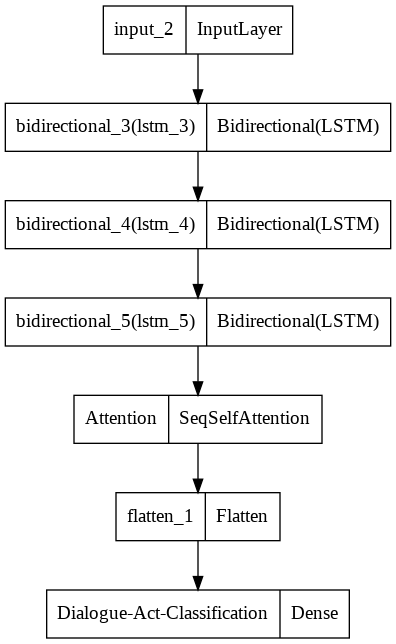

In [ ]:
from tensorflow.keras.utils import plot_model
#plot_model(model, show_shapes=True)
plot_model(model)

In [ ]:
from wandb.keras import WandbCallback

callback = WandbCallback(
    monitor="val_loss", verbose=1, mode="min", save_weights_only=(False),
    log_weights=(False), log_gradients=(False), save_model=(True),
    training_data=(X_train, y_train), validation_data=(X_valid, y_valid), labels=list(label_encoder.inverse_transform(range(3))), predictions=36,
    generator=None, input_type=None, output_type=None, log_evaluation=(False),
    validation_steps=None, class_colors=None, log_batch_frequency=None,
    log_best_prefix="best_", save_graph=(True), validation_indexes=None,
    validation_row_processor=None, prediction_row_processor=None,
    infer_missing_processors=(True), log_evaluation_frequency=0,
)

In [ ]:
#Fit the model on training data
history = model.fit(X_train, dac_y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, dac_y_valid))#, callbacks=[callback])

Epoch 1/25
35/35 [==============================] - 22s 242ms/step - loss: 0.6046 - accuracy: 0.7308 - val_loss: 0.2377 - val_accuracy: 0.9418
Epoch 2/25
35/35 [==============================] - 3s 92ms/step - loss: 0.1519 - accuracy: 0.9627 - val_loss: 0.2171 - val_accuracy: 0.9438
Epoch 3/25
35/35 [==============================] - 3s 90ms/step - loss: 0.1040 - accuracy: 0.9710 - val_loss: 0.1621 - val_accuracy: 0.9518
Epoch 4/25
35/35 [==============================] - 3s 86ms/step - loss: 0.0837 - accuracy: 0.9757 - val_loss: 0.1552 - val_accuracy: 0.9578
Epoch 5/25
35/35 [==============================] - 3s 88ms/step - loss: 0.0853 - accuracy: 0.9759 - val_loss: 0.1487 - val_accuracy: 0.9659
Epoch 6/25
35/35 [==============================] - 3s 83ms/step - loss: 0.0768 - accuracy: 0.9806 - val_loss: 0.1287 - val_accuracy: 0.9639
Epoch 7/25
35/35 [==============================] - 3s 87ms/step - loss: 0.0709 - accuracy: 0.9795 - val_loss: 0.1473 - val_accuracy: 0.9659
Epoch 8/25


In [ ]:
# run = wandb.init(reinit=True)

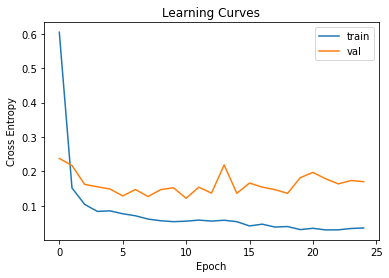

In [ ]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
#Evaluate the model performance on test data
model_score = model.evaluate(X_test, np.array(dac_y_test), batch_size = BATCH_SIZE)

7/7 [==============================] - 0s 39ms/step - loss: 0.0929 - accuracy: 0.9854


In [ ]:
import random
#Predict the dialogue acts
for i in random.sample(range(1, 498), 7):
    #print(i)
    prediction = (model.predict(np.expand_dims(X_test[i],axis=0)) > 0.5).astype("int32")
    print("Input Query  "+test_df["sentences"][i])
    print("Expected DAC:  "+test_df["dac"][i])
    print("Predicted DAC: "+dac_label_encoder.inverse_transform([np.argmax(prediction, axis=None, out=None)]))
    print('*'*75)

Input Query  list flights from newark to houston
Expected DAC:  command
['Predicted DAC: command']
***************************************************************************
Input Query  please list flights from milwaukee to philadelphia
Expected DAC:  command
['Predicted DAC: command']
***************************************************************************
Input Query  what is the lowest fare for a flight from washington dc to boston
Expected DAC:  question
['Predicted DAC: question']
***************************************************************************
Input Query  list airlines flying from seattle to salt lake city
Expected DAC:  command
['Predicted DAC: command']
***************************************************************************
Input Query  show me round trip flights from chicago to detroit leaving next tuesday and returning the day after
Expected DAC:  command
['Predicted DAC: command']
**************************************************************************

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    1.00000   0.97236   0.98599       398
           1    0.94783   1.00000   0.97321       218
           2    0.99638   0.99278   0.99458       277

    accuracy                        0.98544       893
   macro avg    0.98140   0.98838   0.98459       893
weighted avg    0.98614   0.98544   0.98553       893



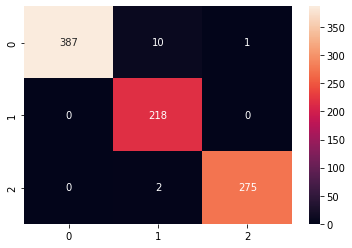

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
y_test = [np.argmax(y, axis=None, out=None) for y in dac_y_test]
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

## Intents

In [ ]:
!nvidia-smi

Sat Feb  5 12:33:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_train.pkl')
valid_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_valid.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_test.pkl')

In [ ]:
train_df.head()

,sentences,dac,intents,slots,bert_embeddings,charcnn_embeddings,padded_sentences,intelligent_concatenated_representation
0,show me all the delta flights leaving or arriv...,command,atis_flight,O O O O B-airline_name O O O O O B-toloc.city_...,"[[-0.11299035, -0.27697983, 0.371804, -0.56227...","[[0.9620004, 0.0, 1.2165515, 0.0, 0.70012015, ...",show me all the delta flights leaving or arriv...,"[[-0.11299035, -0.27697983, 0.371804, -0.56227..."
1,flights from cleveland to miami,info,atis_flight,O O B-fromloc.city_name O B-toloc.city_name,"[[0.72878355, -0.7770693, -0.29467422, -0.3248...","[[0.9620004, 0.0, 1.2165515, 0.0, 0.70012015, ...",flights from cleveland to miami <UNK> <UNK> <U...,"[[0.72878355, -0.7770693, -0.29467422, -0.3248..."
2,which transcontinental flight on united airlin...,question,atis_flight,O O O O B-airline_name I-airline_name O B-from...,"[[-0.017026301, -0.18651861, -0.29448518, -0.2...","[[0.9620004, 0.0, 1.2165515, 0.0, 0.70012015, ...",which transcontinental flight on united airlin...,"[[-0.017026301, -0.18651861, -0.29448518, -0.2..."
3,what flights are available from boston to denv...,question,atis_flight,O O O O O B-fromloc.city_name O B-toloc.city_n...,"[[-0.23178335, 0.17259867, -0.12882315, -0.439...","[[0.9620004, 0.0, 1.2165515, 0.0, 0.70012015, ...",what flights are available from boston to denv...,"[[-0.23178335, 0.17259867, -0.12882315, -0.439..."
4,show flights from san francisco to denver on e...,command,atis_flight,O O O B-fromloc.city_name I-fromloc.city_name ...,"[[-0.11299035, -0.27697983, 0.371804, -0.56227...","[[0.9620004, 0.0, 1.2165515, 0.0, 0.70012015, ...",show flights from san francisco to denver on e...,"[[-0.11299035, -0.27697983, 0.371804, -0.56227..."


In [ ]:
from sklearn import preprocessing
intent_label_encoder = preprocessing.LabelEncoder()
df = pd.concat([train_df,valid_df,test_df],axis = 0)
intent_label_encoder.fit(df["intents"])

train_df['label_encoded_intents'] = intent_label_encoder.transform(train_df['intents'])
valid_df['label_encoded_intents'] = intent_label_encoder.transform(valid_df['intents'])
test_df['label_encoded_intents'] = intent_label_encoder.transform(test_df['intents'])

dataset_train_classes = train_df['label_encoded_intents'].values
dataset_train_class_list = [x for x in dataset_train_classes]

dataset_valid_classes = valid_df['label_encoded_intents'].values
dataset_valid_class_list = [x for x in dataset_valid_classes]

dataset_test_classes = test_df['label_encoded_intents'].values
dataset_test_class_list = [x for x in dataset_test_classes]

from tensorflow.keras.utils import to_categorical
dataset_train_classes = to_categorical(dataset_train_class_list, num_classes = 16) #, num_classes = 27)
dataset_valid_classes = to_categorical(dataset_valid_class_list, num_classes = 16)
dataset_test_classes = to_categorical(dataset_test_class_list, num_classes = 16) #, num_classes = 27)

In [ ]:
import numpy as np
intent_y_train = dataset_train_classes
intent_y_valid = dataset_valid_classes
intent_y_test = dataset_test_classes

In [ ]:
import numpy as np

def applyall(i):
    return np.asarray(i)

X_train = train_df['intelligent_concatenated_representation']
X_train = X_train.values
X_train = applyall(X_train)
X_train = np.stack(X_train)
print(X_train.shape)

X_valid = valid_df['intelligent_concatenated_representation']
X_valid = X_valid.values
X_valid = applyall(X_valid)
X_valid = np.stack(X_valid)
print(X_valid.shape)

X_test = test_df['intelligent_concatenated_representation']
X_test = X_test.values
X_test = applyall(X_test)
X_test = np.stack(X_test)
print(X_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)


In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(intent_y_train.shape)
print(intent_y_valid.shape)
print(intent_y_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)
(4480, 16)
(498, 16)
(893, 16)


In [ ]:
!pip install keras-self-attention

In [ ]:
import wandb

wandb.init(project="AutomaticInquirySystem", entity="fyp-ais-2022")

In [ ]:
# run = wandb.init(reinit=True)

In [ ]:
import pandas as pd 
import numpy as np 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D, Dropout, GRU, Input

import nltk
import re
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
import keras
from keras_self_attention import SeqSelfAttention

BATCH_SIZE = 128
EPOCHS = 25
EMBEDDING_DIM = 484
NUM_UNITS = 128
MAX_SEQ_LEN = 24


model = Sequential()
model.add(Input(shape=(MAX_SEQ_LEN,EMBEDDING_DIM), dtype='float64'))
model.add(Bidirectional( keras.layers.LSTM( units=128, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(keras.layers.LSTM(units=128, return_sequences=True)))

#89.35 % val - Multiplicative accuracy
model.add(SeqSelfAttention(
    attention_width=15,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_attention_bias=False,
    name='Attention',
))

model.add(Flatten())
model.add(keras.layers.Dense(units=16, activation='softmax', name = 'Intent-Detection'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 24, 256)          627712    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 24, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 24, 256)          394240    
 onal)                                                           
                                                                 
 Attention (SeqSelfAttention  (None, 24, 256)          65536     
 )                                                               
                                                                 
 flatten_3 (Flatten)         (None, 6144)             

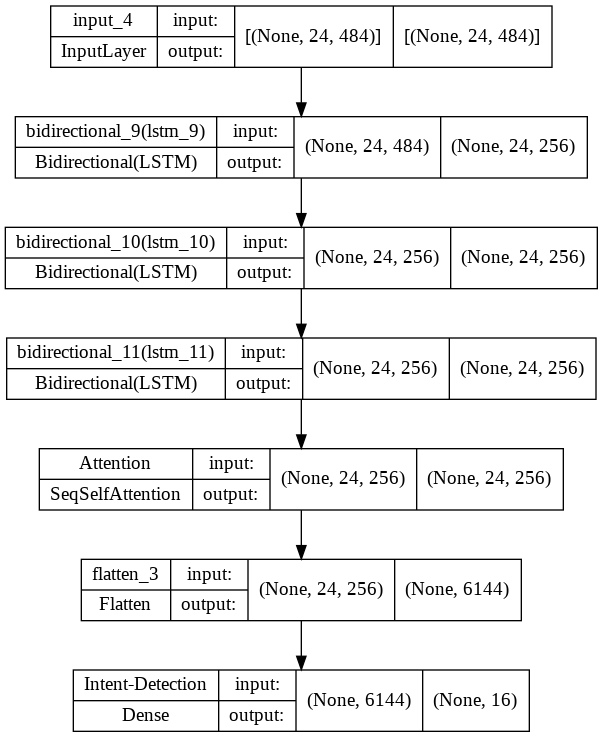

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)
#plot_model(model)

In [ ]:
from wandb.keras import WandbCallback

callback = WandbCallback(
    monitor="val_loss", verbose=1, mode="min", save_weights_only=(False),
    log_weights=(False), log_gradients=(False), save_model=(True),
    training_data=(X_train, y_train), validation_data=(X_valid, y_valid), labels=list(label_encoder.inverse_transform(range(16))), predictions=36,
    generator=None, input_type=None, output_type=None, log_evaluation=(False),
    validation_steps=None, class_colors=None, log_batch_frequency=None,
    log_best_prefix="best_", save_graph=(True), validation_indexes=None,
    validation_row_processor=None, prediction_row_processor=None,
    infer_missing_processors=(True), log_evaluation_frequency=0,
)

In [ ]:
#Fit the model on training data
history = model.fit(X_train, intent_y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, intent_y_valid))#,callbacks=[callback])

Epoch 1/25
35/35 [==============================] - 20s 155ms/step - loss: 0.9598 - accuracy: 0.7500 - val_loss: 0.5434 - val_accuracy: 0.8655
Epoch 2/25
35/35 [==============================] - 3s 76ms/step - loss: 0.4543 - accuracy: 0.8844 - val_loss: 0.2799 - val_accuracy: 0.9257
Epoch 3/25
35/35 [==============================] - 2s 66ms/step - loss: 0.2420 - accuracy: 0.9377 - val_loss: 0.1799 - val_accuracy: 0.9478
Epoch 4/25
35/35 [==============================] - 2s 64ms/step - loss: 0.1359 - accuracy: 0.9645 - val_loss: 0.1721 - val_accuracy: 0.9558
Epoch 5/25
35/35 [==============================] - 2s 64ms/step - loss: 0.0979 - accuracy: 0.9721 - val_loss: 0.0961 - val_accuracy: 0.9779
Epoch 6/25
35/35 [==============================] - 2s 64ms/step - loss: 0.0787 - accuracy: 0.9790 - val_loss: 0.0869 - val_accuracy: 0.9759
Epoch 7/25
35/35 [==============================] - 2s 63ms/step - loss: 0.0619 - accuracy: 0.9844 - val_loss: 0.0622 - val_accuracy: 0.9880
Epoch 8/25


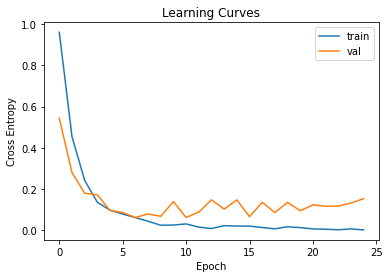

In [ ]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
#Evaluate the model performance on test data
model_score = model.evaluate(X_test, intent_y_test, batch_size = BATCH_SIZE)

7/7 [==============================] - 0s 37ms/step - loss: 0.1257 - accuracy: 0.9866


In [ ]:
import random
#Predict the intents
for i in random.sample(range(1, 893), 7):
    #print(i)
    prediction = (model.predict(np.expand_dims(X_test[i],axis=0)) > 0.5).astype("int32")
    print("Input Query  "+test_df["sentences"][i])
    print("Expected Intent:  "+test_df["intents"][i])
    print("Predicted Intent: "+intent_label_encoder.inverse_transform([np.argmax(prediction, axis=None, out=None)]))
    print('*'*75)

Input Query  what does hp stand for
Expected Intent:  atis_abbreviation
['Predicted Intent: atis_abbreviation']
***************************************************************************
Input Query  how far is toronto international from downtown
Expected Intent:  atis_distance
['Predicted Intent: atis_distance']
***************************************************************************
Input Query  what airline is dl
Expected Intent:  atis_airline
['Predicted Intent: atis_airline']
***************************************************************************
Input Query  list a flight on american airlines from toronto to san diego
Expected Intent:  atis_flight
['Predicted Intent: atis_flight']
***************************************************************************
Input Query  please find a flight from orlando to kansas city
Expected Intent:  atis_flight
['Predicted Intent: atis_flight']
***************************************************************************
Input Query  show 

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    1.00000   0.96970   0.98462        33
           1    1.00000   0.88889   0.94118         9
           2    1.00000   1.00000   1.00000        49
           3    0.97436   1.00000   0.98701        38
           4    1.00000   0.94444   0.97143        18
           5    0.95238   0.95238   0.95238        21
           6    1.00000   0.66667   0.80000         6
           7    1.00000   1.00000   1.00000        10
           8    0.99534   0.99073   0.99303       647
           9    1.00000   1.00000   1.00000         9
          10    0.33333   1.00000   0.50000         1
          11    1.00000   1.00000   1.00000         7
          12    1.00000   1.00000   1.00000        36
          13    0.85714   1.00000   0.92308         6
          14    0.42857   1.00000   0.60000         3

    accuracy                        0.98656       893
   macro avg    0.90274   0

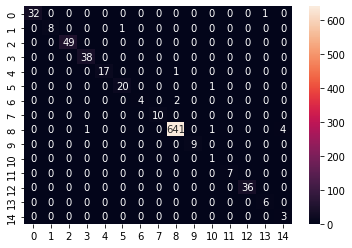

In [ ]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
y_test = [np.argmax(y, axis=None, out=None) for y in intent_y_test]
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

## Slot Filling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_train.pkl')
valid_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_valid.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_test.pkl')

In [ ]:
import numpy as np

def applyall(i):
    return np.asarray(i)

X_train = train_df['intelligent_concatenated_representation']
X_train = X_train.values
X_train = applyall(X_train)
X_train = np.stack(X_train)
print(X_train.shape)

X_valid = valid_df['intelligent_concatenated_representation']
X_valid = X_valid.values
X_valid = applyall(X_valid)
X_valid = np.stack(X_valid)
print(X_valid.shape)

X_test = test_df['intelligent_concatenated_representation']
X_test = X_test.values
X_test = applyall(X_test)
X_test = np.stack(X_test)
print(X_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)


In [ ]:
df = pd.concat([train_df,valid_df,test_df],axis = 0)

In [ ]:
import numpy as np
slot_y_train = train_df['slots']
slot_y_valid = valid_df['slots']
slot_y_test = test_df['slots']

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(slot_y_train.shape)
print(slot_y_valid.shape)
print(slot_y_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)
(4480,)
(498,)
(893,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

NUM_WORDS = 10000
OOV_TOKEN = "<UNK>"

In [ ]:
y_tokenizer.word_index.keys()

dict_keys(['O', 'B-toloc.city_name', 'B-fromloc.city_name', 'I-toloc.city_name', 'B-depart_date.day_name', 'I-fromloc.city_name', 'B-airline_name', 'B-depart_time.period_of_day', 'I-airline_name', 'B-depart_date.day_number', 'B-depart_date.month_name', 'B-depart_time.time', 'B-round_trip', 'I-round_trip', 'B-depart_time.time_relative', 'B-cost_relative', 'B-flight_mod', 'I-depart_time.time', 'B-city_name', 'B-stoploc.city_name', 'B-arrive_time.time', 'B-class_type', 'B-arrive_time.time_relative', 'I-class_type', 'I-arrive_time.time', 'B-flight_stop', 'B-airline_code', 'I-depart_date.day_number', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-toloc.state_code', 'B-fromloc.airport_name', 'B-depart_date.date_relative', 'B-arrive_date.day_name', 'B-flight_number', 'B-depart_date.today_relative', 'B-fare_basis_code', 'I-airport_name', 'I-city_name', 'B-flight_time', 'B-arrive_time.period_of_day', 'B-or', 'B-fromloc.state_code', 'B-meal_description', 'B-aircraft_code', 'B-meal', 'B-airpo

In [ ]:
y_tokenizer = Tokenizer(filters = '', lower = False, split = ' ')
y_tokenizer.fit_on_texts(list(df["slots"]))

#Convert text to sequences
y_train_seq = y_tokenizer.texts_to_sequences(list(slot_y_train))
y_valid_seq = y_tokenizer.texts_to_sequences(list(slot_y_valid))
y_test_seq = y_tokenizer.texts_to_sequences(list(slot_y_test))

In [ ]:
MAX_SEQ_LEN = 24
y_train_padded = pad_sequences(y_train_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_valid_padded = pad_sequences(y_valid_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_test_padded = pad_sequences(y_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

In [ ]:
#Convert labels to one-hot vectors
slot_y_train_encoded = utils.to_categorical(y_train_padded, num_classes = 128)
slot_y_valid_encoded = utils.to_categorical(y_valid_padded, num_classes = 128)
slot_y_test_encoded = utils.to_categorical(y_test_padded, num_classes = 128)
print(slot_y_train_encoded.shape, slot_y_valid_encoded.shape, slot_y_test_encoded.shape)

(4480, 24, 128) (498, 24, 128) (893, 24, 128)


In [ ]:
import wandb
run = wandb.init(reinit=True)
wandb.init(project="AutomaticInquirySystem", entity="fyp-ais-2022")

In [ ]:
from wandb.keras import WandbCallback

callback = WandbCallback(
    monitor="val_loss", verbose=1, mode="min", save_weights_only=(False),
    log_weights=(False), log_gradients=(False), save_model=(True),
    training_data=(X_train, y_train_encoded), validation_data=(X_valid, y_valid_encoded), labels=list(label_encoder.inverse_transform(range(16))), predictions=36,
    generator=None, input_type=None, output_type=None, log_evaluation=(False),
    validation_steps=None, class_colors=None, log_batch_frequency=None,
    log_best_prefix="best_", save_graph=(True), validation_indexes=None,
    validation_row_processor=None, prediction_row_processor=None,
    infer_missing_processors=(True), log_evaluation_frequency=0,
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, Input
from tensorflow.keras.metrics import Precision, Recall

BATCH_SIZE = 128
EPOCHS = 25
EMBEDDING_DIM = 484
NUM_UNITS = 128
VOCAB_SIZE = NUM_WORDS
Y_VOCAB_SIZE = 128  #len(y_tokenizer.word_index) + 1


#Define a Bi-LSTM model
bilstm_model = Sequential()
bilstm_model.add(Input(shape=(MAX_SEQ_LEN,EMBEDDING_DIM)))

bilstm_model.add(Bidirectional(LSTM(NUM_UNITS,  return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(NUM_UNITS,  return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(NUM_UNITS, return_sequences=True)))

bilstm_model.add(TimeDistributed(Dense(Y_VOCAB_SIZE, activation='softmax'),name='Slot-Filling'))


#Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])

bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirecti  (None, 24, 256)          627712    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 24, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_20 (Bidirecti  (None, 24, 256)          394240    
 onal)                                                           
                                                                 
 Slot-Filling (TimeDistribut  (None, 24, 128)          32896     
 ed)                                                             
                                                                 
Total params: 1,449,088
Trainable params: 1,449,088
Non-

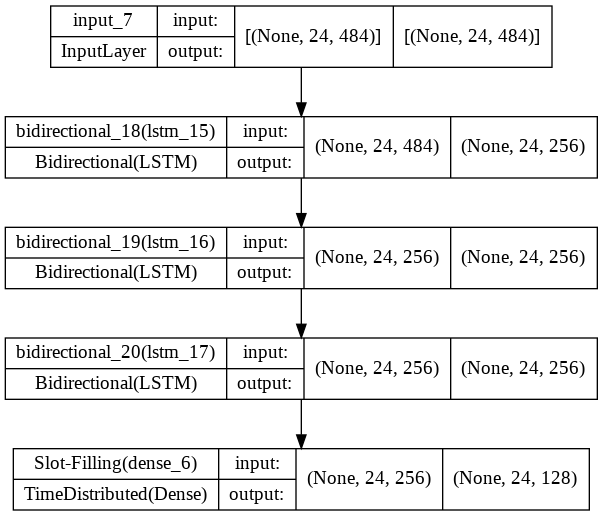

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(bilstm_model, show_shapes=True)
#plot_model(bilstm_model)

In [ ]:
#Fit the model on training data
bilstm_history = bilstm_model.fit(X_train, slot_y_train_encoded, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(X_valid, slot_y_valid_encoded))#,callbacks=[callback])

Epoch 1/25
35/35 [==============================] - 17s 169ms/step - loss: 1.2149 - precision_6: 0.8693 - recall_6: 0.6919 - accuracy: 0.7767 - val_loss: 0.8155 - val_precision_6: 0.8727 - val_recall_6: 0.7951 - val_accuracy: 0.8285
Epoch 2/25
35/35 [==============================] - 3s 82ms/step - loss: 0.7540 - precision_6: 0.8969 - recall_6: 0.7869 - accuracy: 0.8377 - val_loss: 0.7322 - val_precision_6: 0.9057 - val_recall_6: 0.7964 - val_accuracy: 0.8357
Epoch 3/25
35/35 [==============================] - 3s 75ms/step - loss: 0.6011 - precision_6: 0.9490 - recall_6: 0.8310 - accuracy: 0.8724 - val_loss: 0.5194 - val_precision_6: 0.9626 - val_recall_6: 0.8671 - val_accuracy: 0.8908
Epoch 4/25
35/35 [==============================] - 2s 71ms/step - loss: 0.4233 - precision_6: 0.9758 - recall_6: 0.8840 - accuracy: 0.9065 - val_loss: 0.3980 - val_precision_6: 0.9736 - val_recall_6: 0.8901 - val_accuracy: 0.9127
Epoch 5/25
35/35 [==============================] - 3s 72ms/step - loss: 0

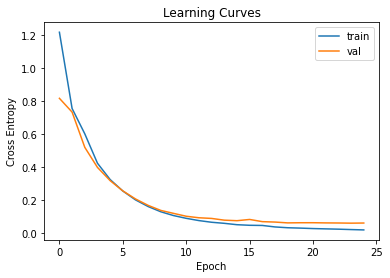

In [ ]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
pyplot.plot(bilstm_history.history['loss'], label='train')
pyplot.plot(bilstm_history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
#Evaluate the model performance on test data
bilstm_score = bilstm_model.evaluate(X_test, slot_y_test_encoded, batch_size = BATCH_SIZE)

7/7 [==============================] - 0s 40ms/step - loss: 0.0697 - precision: 0.9903 - recall: 0.9855 - accuracy: 0.9876


In [ ]:
model = bilstm_model

In [ ]:
label_list = list(y_tokenizer.word_index.keys())
index_list = list(y_tokenizer.word_index.values())

import random
#Predict the slots
for i in random.sample(range(1, 893), 3):
    #print(i)
    prediction = model.predict(np.expand_dims(X_test[i],axis=0))
    slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[0][:]] if j in index_list]
    print("Input Query  "+test_df["sentences"][i])
    print()
    print("Expected Slots:  "+test_df["slots"][i])
    print()
    print("Predicted Slots: ",slots)
    print('*'*75)

Input Query  what does the restriction ap58 mean

Expected Slots:  O O O O B-restriction_code O

Predicted Slots:  ['O', 'O', 'O', 'O', 'B-restriction_code', 'O']
***************************************************************************
Input Query  please find a flight from las vegas to michigan

Expected Slots:  O O O O O B-fromloc.city_name I-fromloc.city_name O B-toloc.state_name

Predicted Slots:  ['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'I-fromloc.city_name', 'O', 'B-toloc.city_name']
***************************************************************************
Input Query  list airlines flying from seattle to salt lake city

Expected Slots:  O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name I-toloc.city_name

Predicted Slots:  ['O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'I-toloc.city_name']
***************************************************************************


In [ ]:
label_list = list(y_tokenizer.word_index.keys())
index_list = list(y_tokenizer.word_index.values())

import random
#Predict the slots
for i in random.sample(range(1, 893), 7):
    #print(i)
    prediction = bilstm_model.predict(np.expand_dims(X_test[i],axis=0))
    slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[0][:]] if j in index_list]
    print("Input Query  "+test_df["sentences"][i])
    print("Expected Slots:  "+test_df["slots"][i])
    print("Predicted Slots: "+slots)
    print('*'*75)

272
cleveland to nashville flight friday morning
['B-fromloc.city_name', 'O', 'B-toloc.city_name', 'O', 'B-depart_date.day_name', 'B-depart_time.period_of_day']
***************************************************************************
106
what is the latest flight from baltimore to oakland that serves dinner
['O', 'O', 'O', 'B-flight_mod', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'O', 'O', 'B-meal_description']
***************************************************************************
315
and now show me ground transportation that i could get in boston late night
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-toloc.city_name', 'B-period_of_day', 'B-period_of_day']
***************************************************************************
494
i need a flight from salt lake city to phoenix departing wednesday after 5 pm
['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'I-fromloc.city_name', 'I-fromloc.city_name', 'O', 'B-toloc.city_name', 'O', 'B-depart_

# Intelligent Deep Concurrent Model

In [ ]:
!nvidia-smi

Fri Apr 29 04:55:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=a8dcf678da0f083c0072acd7716f104be3eb3b4e841bc3e09b5aa6403b73ea41
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
import pandas as pd 
import numpy as np 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D, Dropout, GRU, Input, TimeDistributed

import nltk
import re
from textblob import Word, TextBlob

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

import keras
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils

from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.merge import add

In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_train.pkl')
valid_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_valid.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Datasets/WordLevelRepresentation/ATIS/atis_test.pkl')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4480 entries, 0 to 4479
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   sentences                                4480 non-null   object
 1   dac                                      4480 non-null   object
 2   intents                                  4480 non-null   object
 3   slots                                    4480 non-null   object
 4   bert_embeddings                          4480 non-null   object
 5   charcnn_embeddings                       4480 non-null   object
 6   padded_sentences                         4480 non-null   object
 7   intelligent_concatenated_representation  4480 non-null   object
dtypes: object(8)
memory usage: 280.1+ KB


In [ ]:
def applyall(i):
    return np.asarray(i)

X_train = train_df['intelligent_concatenated_representation']
X_train = X_train.values
X_train = applyall(X_train)
X_train = np.stack(X_train)
print(X_train.shape)

X_valid = valid_df['intelligent_concatenated_representation']
X_valid = X_valid.values
X_valid = applyall(X_valid)
X_valid = np.stack(X_valid)
print(X_valid.shape)

X_test = test_df['intelligent_concatenated_representation']
X_test = X_test.values
X_test = applyall(X_test)
X_test = np.stack(X_test)
print(X_test.shape)

(4480, 24, 484)
(498, 24, 484)
(893, 24, 484)


In [ ]:
DISTINCT_SLOT   = 128
DISTINCT_INTENT = 16
DISTINCT_DA     =  3

MAX_SEQ_LEN = X_train[0].shape[0]   # 24
EMBEDDING_DIM = X_train[0].shape[1] # 484

In [ ]:
EMBEDDING_DIM

384

## Dialogue Act Classification

In [ ]:
dac_label_encoder = preprocessing.LabelEncoder()
df = pd.concat([train_df,valid_df,test_df],axis = 0)
dac_label_encoder.fit(df["dac"])
train_df['label_encoded_dac'] = dac_label_encoder.transform(train_df['dac'])
valid_df['label_encoded_dac'] = dac_label_encoder.transform(valid_df['dac'])
test_df['label_encoded_dac'] = dac_label_encoder.transform(test_df['dac'])

dataset_train_classes = train_df['label_encoded_dac'].values
dataset_train_class_list = [x for x in dataset_train_classes]

dataset_valid_classes = valid_df['label_encoded_dac'].values
dataset_valid_class_list = [x for x in dataset_valid_classes]

dataset_test_classes = test_df['label_encoded_dac'].values
dataset_test_class_list = [x for x in dataset_test_classes]

dataset_train_classes = to_categorical(dataset_train_class_list, num_classes = DISTINCT_DA)
dataset_valid_classes = to_categorical(dataset_valid_class_list, num_classes = DISTINCT_DA)
dataset_test_classes = to_categorical(dataset_test_class_list, num_classes = DISTINCT_DA)

In [ ]:
dac_y_train = dataset_train_classes
dac_y_valid = dataset_valid_classes
dac_y_test = dataset_test_classes

## Intent Detection

In [ ]:
intent_label_encoder = preprocessing.LabelEncoder()
df = pd.concat([train_df,valid_df,test_df],axis = 0)
intent_label_encoder.fit(df["intents"])

train_df['label_encoded_intents'] = intent_label_encoder.transform(train_df['intents'])
valid_df['label_encoded_intents'] = intent_label_encoder.transform(valid_df['intents'])
test_df['label_encoded_intents'] = intent_label_encoder.transform(test_df['intents'])

dataset_train_classes = train_df['label_encoded_intents'].values
dataset_train_class_list = [x for x in dataset_train_classes]

dataset_valid_classes = valid_df['label_encoded_intents'].values
dataset_valid_class_list = [x for x in dataset_valid_classes]

dataset_test_classes = test_df['label_encoded_intents'].values
dataset_test_class_list = [x for x in dataset_test_classes]

In [ ]:
dataset_train_classes = to_categorical(dataset_train_class_list, num_classes = DISTINCT_INTENT)
dataset_valid_classes = to_categorical(dataset_valid_class_list, num_classes = DISTINCT_INTENT)
dataset_test_classes = to_categorical(dataset_test_class_list, num_classes = DISTINCT_INTENT) 

intent_y_train = dataset_train_classes
intent_y_valid = dataset_valid_classes
intent_y_test = dataset_test_classes

## Slot Filling

In [ ]:
import numpy as np
slot_y_train = train_df['slots']
slot_y_valid = valid_df['slots']
slot_y_test = test_df['slots']

In [ ]:
y_tokenizer = Tokenizer(filters = '', lower = False, split = ' ')
y_tokenizer.fit_on_texts(list(df["slots"]))

#Convert text to sequences
y_train_seq = y_tokenizer.texts_to_sequences(list(slot_y_train))
y_valid_seq = y_tokenizer.texts_to_sequences(list(slot_y_valid))
y_test_seq = y_tokenizer.texts_to_sequences(list(slot_y_test))

In [ ]:
y_train_padded = pad_sequences(y_train_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_valid_padded = pad_sequences(y_valid_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
y_test_padded = pad_sequences(y_test_seq, maxlen = MAX_SEQ_LEN, padding = 'post')

#Convert labels to one-hot vectors
slot_y_train_encoded = utils.to_categorical(y_train_padded, num_classes = DISTINCT_SLOT)
slot_y_valid_encoded = utils.to_categorical(y_valid_padded, num_classes = DISTINCT_SLOT)
slot_y_test_encoded = utils.to_categorical(y_test_padded, num_classes = DISTINCT_SLOT)
print(slot_y_train_encoded.shape, slot_y_valid_encoded.shape, slot_y_test_encoded.shape)

(4480, 24, 128) (498, 24, 128) (893, 24, 128)


## Multi Task Model Defining

In [ ]:
BATCH_SIZE = 128
EPOCHS = 50
NUM_UNITS = 100
ATTENTION_WIDTH = 15

### Non residual

In [ ]:
model_input = Input(shape=(MAX_SEQ_LEN,EMBEDDING_DIM), dtype='float64')
x = Bidirectional(GRU( NUM_UNITS, return_sequences=True))(model_input)
x = Bidirectional(GRU( NUM_UNITS, return_sequences=True))(x)
x = Bidirectional(GRU( NUM_UNITS, return_sequences=True))(x)


x1 = SeqSelfAttention(
    attention_width=ATTENTION_WIDTH,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_attention_bias=False,
    attention_regularizer_weight=1e-4,
    name='Attention_dac',
)(x)
x1 = Flatten()(x1)

x2 = SeqSelfAttention(
    attention_width=ATTENTION_WIDTH,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_attention_bias=False,
    attention_regularizer_weight=1e-4,
    name='Attention_intent',
)(x)
x2 = Flatten()(x2)

y1=Dense(DISTINCT_DA,activation='softmax', name='Dialogue-Act-Classification')(x1)
y2=Dense(DISTINCT_INTENT,activation='softmax',name='Intent-Detection')(x2)
y3 = TimeDistributed(Dense(DISTINCT_SLOT, activation='softmax'), name = 'Slot-Filling')(x)

model=Model(inputs=model_input,outputs=[y1,y2,y3])

model.compile(loss='categorical_crossentropy',loss_weights = [3,3,3],
                  optimizer='adam',
                  metrics=['accuracy', Precision(), Recall()])

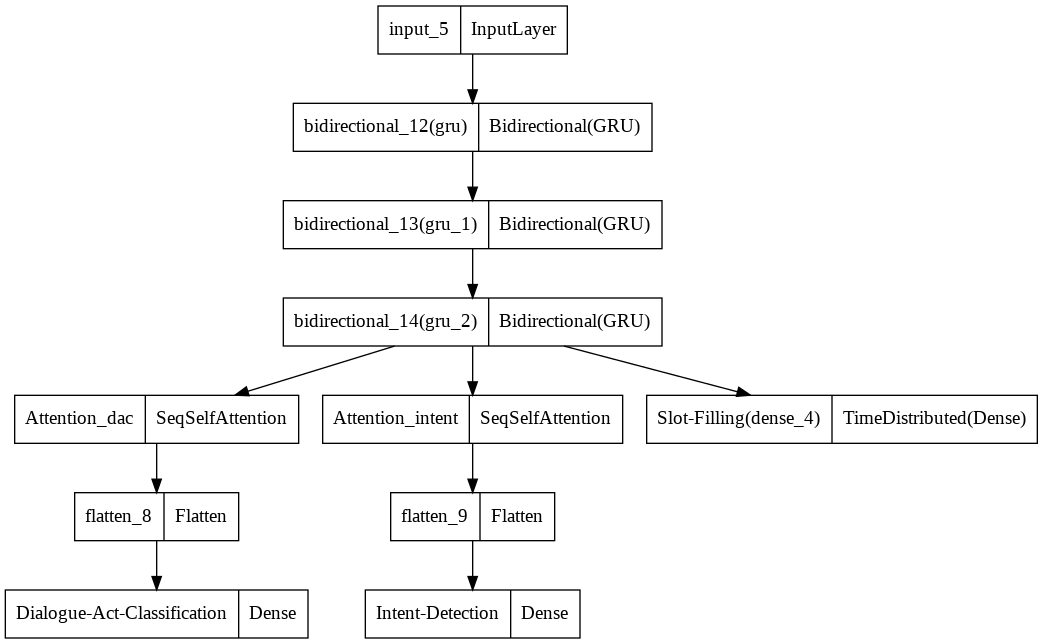

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 24, 384)]    0           []                               
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 24, 200)     291600      ['input_5[0][0]']                
 l)                                                                                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 24, 200)     181200      ['bidirectional_12[0][0]']       
 l)                                                                                               
                                                                                            

### Residual

In [ ]:
model_input = Input(shape=(MAX_SEQ_LEN,EMBEDDING_DIM), dtype='float64')
layer_1 = Bidirectional(LSTM( NUM_UNITS, return_sequences=True))(model_input)
#layer_1 = Dropout(0.5)(layer_1)
layer_2 = Bidirectional(LSTM( NUM_UNITS, return_sequences=True))(layer_1)
#layer_2 = Dropout(0.5)(layer_2)
add_1 = add([layer_1,layer_2])
layer_3 = Bidirectional(LSTM( NUM_UNITS, return_sequences=True))(add_1)
#layer_3 = Dropout(0.5)(layer_3)
add_2 = add([add_1,layer_3])

x1 = SeqSelfAttention(
    attention_width=ATTENTION_WIDTH,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None,
    kernel_regularizer=keras.regularizers.l2(1e-6),
    use_attention_bias=False,
    attention_regularizer_weight=1e-4,
    name='Attention_dac',
)(add_2)
x1 = Flatten()(x1)

x2 = SeqSelfAttention(
    attention_width=ATTENTION_WIDTH,
    attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
    attention_activation=None,
    kernel_regularizer=keras.regularizers.l2(1e-5),
    use_attention_bias=False,
    attention_regularizer_weight=1e-4,
    name='Attention_intent',
)(add_2)
x2 = Flatten()(x2)

y1=Dense(DISTINCT_DA,activation='softmax', name='Dialogue-Act-Classification')(x1)
y2=Dense(DISTINCT_INTENT,activation='softmax',name='Intent-Detection')(x2)
y3 = TimeDistributed(Dense(DISTINCT_SLOT, activation='softmax'), name = 'Slot-Filling')(add_2)

model=Model(inputs=model_input,outputs=[y1,y2,y3])

model.compile(loss='categorical_crossentropy',loss_weights = [0.5,2,1],
                  optimizer='adam',
                  metrics=['accuracy', Precision(), Recall()])

###Training

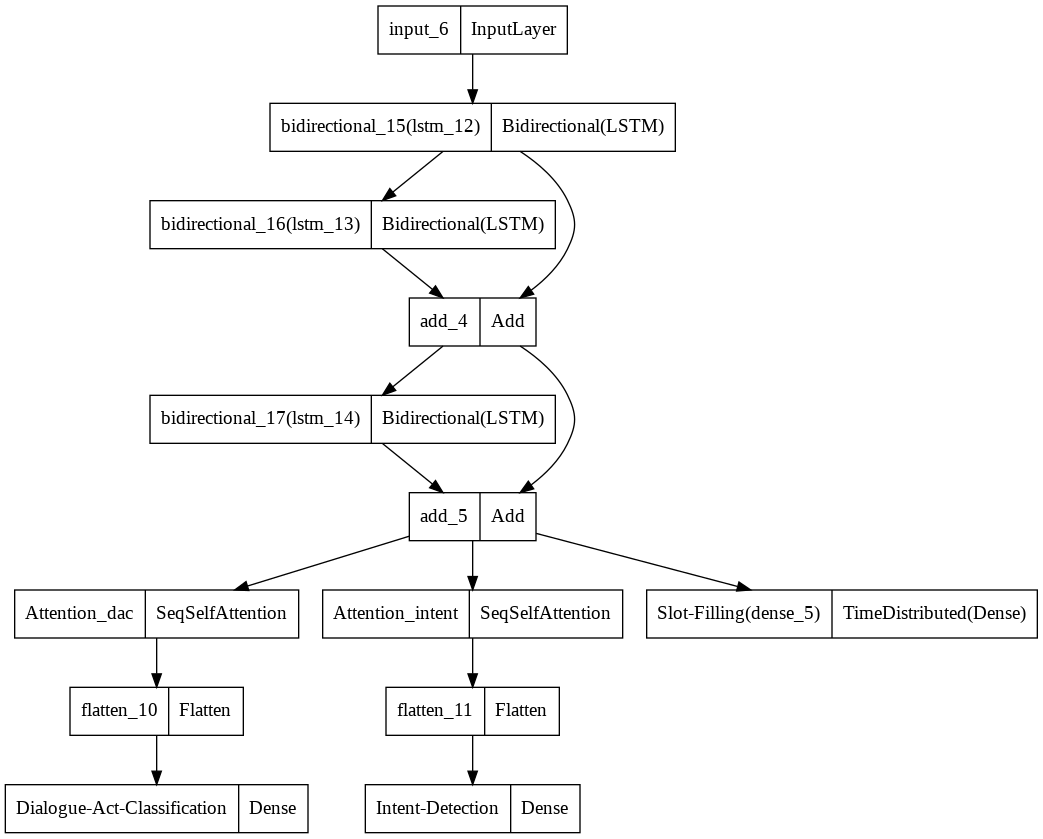

In [ ]:
plot_model(model)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 24, 384)]    0           []                               
                                                                                                  
 bidirectional_15 (Bidirectiona  (None, 24, 200)     388000      ['input_6[0][0]']                
 l)                                                                                               
                                                                                                  
 bidirectional_16 (Bidirectiona  (None, 24, 200)     240800      ['bidirectional_15[0][0]']       
 l)                                                                                               
                                                                                            

In [ ]:
ep = EarlyStopping(
    monitor='val_loss', 
    patience=5,
)
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("multitask_atis_model_history_log.csv", append=True)

In [ ]:
!pip install wandb

In [ ]:
import wandb

In [ ]:
wandb.login()

wandb: Currently logged in as: fyp-ais-2022 (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(project="fyp")

In [ ]:
from wandb.keras import WandbCallback

callback = WandbCallback(
    monitor="val_loss", verbose=1, mode="min", save_weights_only=(False),
    log_weights=(False), log_gradients=(False), save_model=(True),
    generator=None, input_type=None, output_type=None, log_evaluation=(False),
    validation_steps=None, class_colors=None, log_batch_frequency=None,
    log_best_prefix="best_", save_graph=(True), validation_indexes=None,
    validation_row_processor=None, prediction_row_processor=None,
    infer_missing_processors=(True), log_evaluation_frequency=0,
)

In [ ]:
history = model.fit(X_train, [dac_y_train,intent_y_train,slot_y_train_encoded],
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=1,validation_data=(X_valid, [dac_y_valid,intent_y_valid, slot_y_valid_encoded]),callbacks=[callback])
                        #validation_data=(X_valid, [y_valid, dac_y_valid]))

Epoch 1/50
35/35 [==============================] - 24s 218ms/step - loss: 8.9087 - Dialogue-Act-Classification_loss: 0.6563 - Intent-Detection_loss: 1.0252 - Slot-Filling_loss: 1.2880 - Dialogue-Act-Classification_accuracy: 0.6908 - Dialogue-Act-Classification_precision: 0.8030 - Dialogue-Act-Classification_recall: 0.6007 - Intent-Detection_accuracy: 0.7395 - Intent-Detection_precision: 0.7902 - Intent-Detection_recall: 0.7089 - Slot-Filling_accuracy: 0.7982 - Slot-Filling_precision: 0.8792 - Slot-Filling_recall: 0.6527 - val_loss: 5.1231 - val_Dialogue-Act-Classification_loss: 0.2181 - val_Intent-Detection_loss: 0.6667 - val_Slot-Filling_loss: 0.8227 - val_Dialogue-Act-Classification_accuracy: 0.9277 - val_Dialogue-Act-Classification_precision: 0.9273 - val_Dialogue-Act-Classification_recall: 0.9217 - val_Intent-Detection_accuracy: 0.8353 - val_Intent-Detection_precision: 0.8720 - val_Intent-Detection_recall: 0.8072 - val_Slot-Filling_accuracy: 0.8353 - val_Slot-Filling_precision: 0.

In [ ]:
score = model.evaluate(X_test, [dac_y_test,intent_y_test,slot_y_test_encoded], batch_size=256, verbose=1)

4/4 [==============================] - 0s 30ms/step - loss: 1.1921 - Dialogue-Act-Classification_loss: 0.1557 - Intent-Detection_loss: 0.1424 - Slot-Filling_loss: 0.0927 - Dialogue-Act-Classification_accuracy: 0.9664 - Dialogue-Act-Classification_precision_7: 0.9675 - Dialogue-Act-Classification_recall_7: 0.9664 - Intent-Detection_accuracy: 0.9698 - Intent-Detection_precision_7: 0.9719 - Intent-Detection_recall_7: 0.9698 - Slot-Filling_accuracy: 0.9817 - Slot-Filling_precision_7: 0.9896 - Slot-Filling_recall_7: 0.9749


In [ ]:
model.load_weights('/content/my_checkpoint.ckpt')

In [ ]:
model.save('/content/drive/MyDrive/atis_multi_tasksss')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/atis_multi_task/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/atis_multi_task/assets


###Prediction

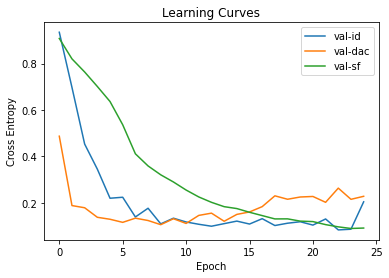

In [ ]:
from matplotlib import pyplot

# plot learning curves
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Cross Entropy')
#pyplot.plot(history.history['Dialogue-Act-Classification_loss'], label='train-dac')
pyplot.plot(history.history['val_Intent-Detection_loss'], label='val-id')
pyplot.plot(history.history['val_Dialogue-Act-Classification_loss'], label='val-dac')
pyplot.plot(history.history['val_Slot-Filling_loss'], label='val-sf')
pyplot.legend()
pyplot.show()

In [ ]:
from keras.models import load_model
model = load_model("/content/drive/MyDrive/atis_multi_task")

In [ ]:
label_list = list(y_tokenizer.word_index.keys())
index_list = list(y_tokenizer.word_index.values())

import random
#Predict the slots
for i in random.sample(range(1, 893), 7):
    print(i)
    print(test_df["sentences"][i])
    prediction = model.predict(np.expand_dims(X_test[i],axis=0))
    dac_prediction = (prediction[0] > 0.5).astype("int32")
    print("Expected Dialogue Act : ",test_df["dac"][i])
    print("Predicted Dialogue Act : ",dac_label_encoder.inverse_transform([np.argmax(dac_prediction, axis=None, out=None)]))
    
    intent_prediction = (prediction[1] > 0.5).astype("int32")
    print("Expected Intent : ",test_df["intents"][i])
    print("Predicted Intent : ",intent_label_encoder.inverse_transform([np.argmax(intent_prediction, axis=None, out=None)]))
    
    slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[2][0][:]] if j in index_list]
    print("Expected Slots : ",test_df["slots"][i])
    print("Predicted Slots : ",slots)
    print('*'*75)

108
to what cities from boston does america west fly first class
Expected Dialogue Act :  question
Predicted Dialogue Act :  ['question']
Expected Intent :  atis_city
Predicted Intent :  ['atis_city']
Expected Slots :  O O O O B-fromloc.city_name O B-airline_name I-airline_name O B-class_type I-class_type
Predicted Slots :  ['O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-airline_name', 'I-airline_name', 'O', 'B-class_type', 'I-class_type']
***************************************************************************
95
which flights arrive in burbank from kansas city on saturdays in the afternoon
Expected Dialogue Act :  question
Predicted Dialogue Act :  ['question']
Expected Intent :  atis_flight
Predicted Intent :  ['atis_flight']
Expected Slots :  O O O O B-toloc.city_name O B-fromloc.city_name I-fromloc.city_name O B-arrive_date.day_name O O B-arrive_time.period_of_day
Predicted Slots :  ['O', 'O', 'O', 'O', 'B-toloc.city_name', 'O', 'B-fromloc.city_name', 'I-fromloc.city_name',

In [ ]:
label_list = list(y_tokenizer.word_index.keys())
index_list = list(y_tokenizer.word_index.values())

import random
#Predict the slots
i = int(input("Enter an index: "))   
print(test_df["sentences"][i])
prediction = model.predict(np.expand_dims(X_test[i],axis=0))
dac_prediction = (prediction[0] > 0.5).astype("int32")
print("Expected Dialogue Act : ",test_df["dac"][i])
print("Predicted Dialogue Act : ",dac_label_encoder.inverse_transform([np.argmax(dac_prediction, axis=None, out=None)]))

intent_prediction = (prediction[1] > 0.5).astype("int32")
print("Expected Intent : ",test_df["intents"][i])
print("Predicted Intent : ",intent_label_encoder.inverse_transform([np.argmax(intent_prediction, axis=None, out=None)]))

slots = [label_list[index_list.index(j)] for j in [np.argmax(x) for x in prediction[2][0][:]] if j in index_list]
print("Expected Slots : ",test_df["slots"][i])
print("Predicted Slots : ",slots)
print('*'*75)

Enter an index: 5
i need a flight from toronto to newark one way leaving wednesday evening or thursday morning
Expected Dialogue Act :  info
Predicted Dialogue Act :  ['info']
Expected Intent :  atis_flight
Predicted Intent :  ['atis_flight']
Expected Slots :  O O O O O B-fromloc.city_name O B-toloc.city_name B-round_trip I-round_trip O B-depart_date.day_name B-depart_time.period_of_day O B-depart_date.day_name B-depart_time.period_of_day
Predicted Slots :  ['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-round_trip', 'I-round_trip', 'O', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-or', 'B-depart_date.day_name', 'B-depart_time.period_of_day']
***************************************************************************
